# Predicting depression through social media

In [1]:
%matplotlib inline
from pyspark.context import SparkContext
import datetime
from os import path
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)


In [2]:
sc = SparkContext.getOrCreate()
truePositivesPath = "../truePositives/*.csv"
trueNegativesPath = "../trueNegatives/*.csv"

## Helper Functions

In [3]:
def isTimeStamp(date_text):
    if date_text is None: 
        return False
    try:
        datetime.datetime.strptime(date_text, '%Y-%m-%d %H:%M:%S')
        return True
    except ValueError, TypeError:
        return False

In [4]:
def make_word_cloud(mask_file_path, text, title):
    """This method creates a word cloud based on the word count from the given text."""
    d = path.dirname(".")
    mask_image = np.array(Image.open(path.join(d, mask_file_path)))
    stopwords = set(STOPWORDS)
    stopwords.add("said")
    stopwords.add("https")
    stopwords.add("co")
    stopwords.add("amp")
    stopwords.add("RT")

    wc = WordCloud(background_color="white", max_words=2000, mask=mask_image, stopwords=stopwords)
    # generate word cloud
    wc.generate(text)

    # store to file
    wc.to_file(path.join(d, title+".png"))
    
    # show
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.figure()
    plt.show() 

## Creating a word cloud 

In [5]:
tp_dataframe = spark.read.options(header="true", parserLib="univocity").csv(truePositivesPath)

tn_dataframe = spark.read.options(header="true", parserLib="univocity").csv(trueNegativesPath)

In [6]:
tp_rdd = tp_dataframe.rdd\
                     .map(list)\
                     .filter(lambda line: isTimeStamp(line[1]))\
                     .cache()
                     
tn_rdd = tn_dataframe.rdd\
                     .map(list)\
                     .filter(lambda line: isTimeStamp(line[1]))\
                     .cache()
                     
            
print tp_rdd.count()
print tn_rdd.count()

85281
70334


In [7]:
tp_text_rdd = tp_rdd.map(lambda line: [str(re.sub(r'[^\x00-\x7F]+',' ', line[-1]))]).cache()
tn_text_rdd = tn_rdd.map(lambda line: [str(re.sub(r'[^\x00-\x7F]+',' ', line[-1]))]).cache()

tp_text_rdd.take(5)
tn_text_rdd.take(5)


[['RT @wvgazettemail: Post-vote talk, alleged Bob Evans gathering debated in Richwood school consolidation hearing -- by @RyanEQuinn'],
 ["Updated story about today's hearing on lawsuit alleging Nicholas school board members violated open meetings laws:  https://t.co/Pw1Ld67pCB"],
 ['RT @wvgazettemail: No decision today after Nicholas school closing arguments https://t.co/3jngRWxX8Y by @RyanEQuinn'],
 ["The judge didn't rule today. Requested both parties submit proposed findings within 10 days"],
 ['Well Webb has now called board member Fred Amick too']]

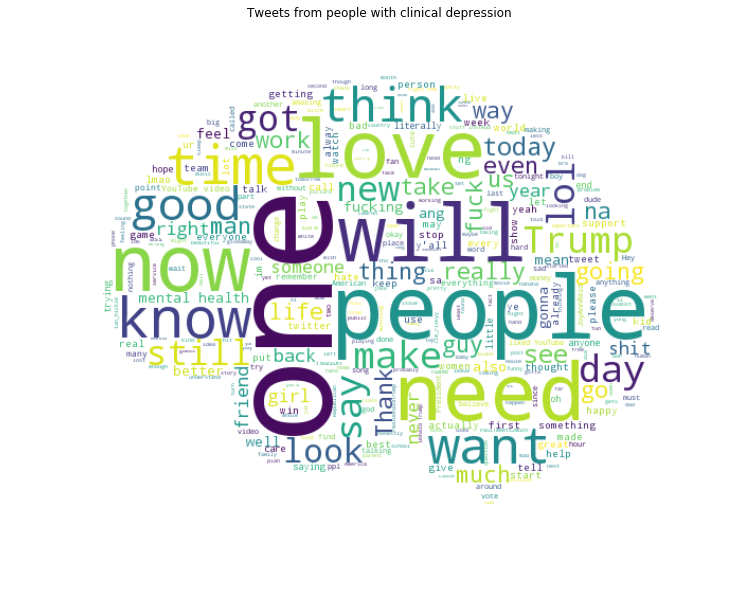

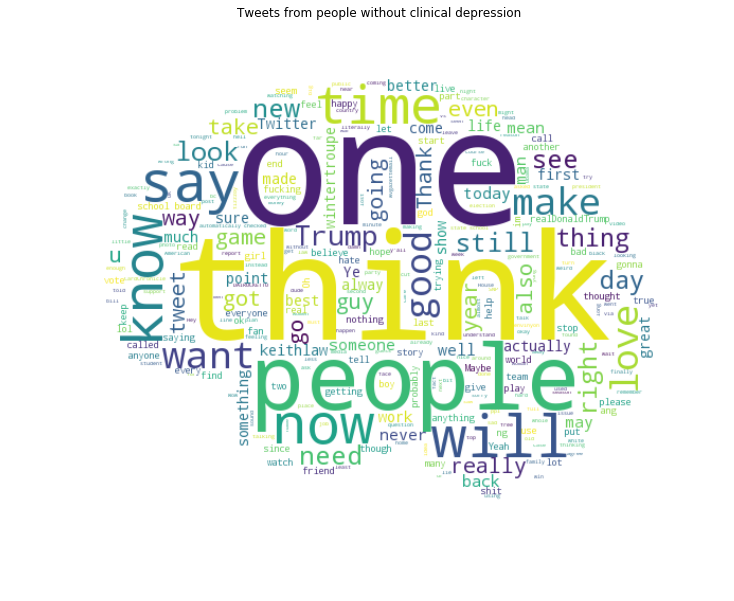

In [8]:
tp_collect = tp_text_rdd.collect()
tn_collect = tn_text_rdd.collect()

tp_text = ''.join(str(r) for v in tp_collect for r in v)
tn_text = ''.join(str(r) for v in tn_collect for r in v)

tp_title = "Tweets from people with clinical depression"
tn_title = "Tweets from people without clinical depression"
make_word_cloud("brain1.jpg", tp_text, tp_title)
make_word_cloud("brain1.jpg", tn_text, tn_title)

## Analyzing the data with TF-IDF

In [9]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator

In [15]:
tp_label_text = tp_text_rdd.map(lambda line : [0, str(line)])
tn_label_text = tn_text_rdd.map(lambda line : [1, str(line)])

tweetRDD = tp_label_text.union(tn_label_text).collect()

tweetsDF = spark.createDataFrame(tweetRDD, ['label', 'tweet'])

splits = tweetsDF.randomSplit([0.6, 0.4])
training_df = splits[0]
test_df = splits[1]


In [16]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
idf = IDF(minDocFreq=3, inputCol="features", outputCol="idf")
nb = NaiveBayes()
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, nb])


paramGrid = ParamGridBuilder().addGrid(nb.smoothing, [0.0, 1.0]).build()


cv = CrossValidator(estimator=pipeline, 
                    estimatorParamMaps=paramGrid, 
                    evaluator=MulticlassClassificationEvaluator(), 
                    numFolds=4)

cvModel = cv.fit(training_df)

In [17]:
result = cvModel.transform(test_df)
prediction_df = result.select("tweet", "label", "prediction")

In [19]:
tpDF = prediction_df.filter(prediction_df['label']==0.0)
tpDF.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|tweet                                                                                                                                          |label|prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|["  A real protester gives Oregon mayor a Pepsi. It didn't end well https://t.co/xDbMwWwXYL via @HuffPostWeird"]                               |0    |0.0       |
|["  Hopefully it's rerouted into their asses! #NoDAPL https://t.co/AZ7Yl43oQC"]                                                                |0    |1.0       |
|[" I'm a perverted alien from the planet Pheromones "]                                                                                         |0    |0.0       |
|[" I'm a perverted al

In [20]:
tnDF = prediction_df.filter(prediction_df['label']==1.0)
tnDF.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|tweet                                                                                                                                           |label|prediction|
+------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|["  It's raining docs today."]                                                                                                                  |1    |1.0       |
|["  May 2013   @potus knows what's up... https://t.co/bVb9N9LoeI"]                                                                              |1    |0.0       |
|["  May 2013   @potus knows what's up...#syriahoax https://t.co/bVb9N9LoeI"]                                                                    |1    |1.0       |
|["  Snow and fr

In [21]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(result, {evaluator.metricName: "accuracy"})

0.785638280720988

In [17]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [18]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(training_df)
featureIndexer =\
    VectorIndexer(inputCol="tweet", outputCol="indexedFeatures", maxCategories=4).fit(data)
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

IllegalArgumentException: u'Field "features" does not exist.'